In [ ]:
'''
Using imblearn to undersample majority class:
Confusion matrix:
[6287903   66504]
[     16    8197]
Best to find FN, so we can catch more frauds.

Using imblearn to oversample minority class:
Confusion matrix:
[6348797    5610]
[     23    8190]
Best to find FP, but a bit less of FN.

Using imblearn to undersample majority class and oversample minority class:
Confusion matrix:
[[6347371    7036]
[      22    8191]
Somehow, this is the best of both worlds. We have a bit more FP, but less FN.
'''

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('./data/PS_20174392719_1491204439457_log.csv')

In [3]:
df['type'].unique().tolist()

['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']

In [4]:
# Only 0,13% of the transactions are fraudulent
(df['isFraud'].value_counts()[1]/df['isFraud'].value_counts()[0])*100

0.129248881917699

In [4]:
# Data is highly imbalanced with only 0.129% of the transactions being fraudulent, so we need to balance the data
# We can see that the fraudulent transactions are only of type 'TRANSFER' and 'CASH_OUT'

df[df['isFraud']==1]['type'].unique().tolist()

['TRANSFER', 'CASH_OUT']

<Axes: xlabel='isFraud', ylabel='count'>

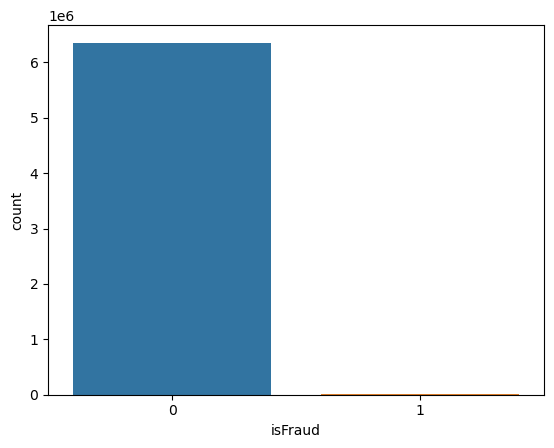

In [5]:
sns.countplot(x='isFraud', data=df)

In [3]:
# copy first letter of nameDest and to new column
df['nameOrig_first'] = df['nameOrig'].str[0]
df['nameDest_first'] = df['nameDest'].str[0]

# drop columns that are not needed
df = df.drop(['step','nameOrig','nameDest'], axis=1)

In [5]:
# Using imbleatn lybrary to balance the data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# split data into train, test and validation sets
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

# encode categorical data
le = LabelEncoder()
columns_to_encode = ['type', 'nameDest_first', 'nameOrig_first']
X[columns_to_encode] = X[columns_to_encode].apply(lambda col: le.fit_transform(col))

X, y = RandomUnderSampler().fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(9855, 8) (9855,)
(3286, 8) (3286,)
(3285, 8) (3285,)


In [5]:
X_train.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,nameOrig_first,nameDest_first
1779241,3,6385.640000,2.566000e+03,0.0,0.000000e+00,0.000000e+00,0,1
11361671,1,426288.581318,4.262886e+05,0.0,1.404453e+06,1.830741e+06,0,0
1398126,4,247806.100000,0.000000e+00,0.0,1.682161e+06,1.929967e+06,0,0
493161,3,14050.680000,2.172000e+03,0.0,0.000000e+00,0.000000e+00,0,1
1369160,0,67643.280000,4.861084e+06,4928726.9,9.993275e+06,9.925632e+06,0,0


In [8]:
#based on the output of LazyClassifier, we can see that the best performing model is XGBClassifier
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [9]:
# On test data
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix

y_pred = xgb_clf.predict(X_test)
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Precision:  0.9987074350413337
Recall:  0.9993851623376112
F1:  0.9990461837512837
ROC AUC:  0.9990431078233024


[[1263228    1643]
 [    781 1269473]]


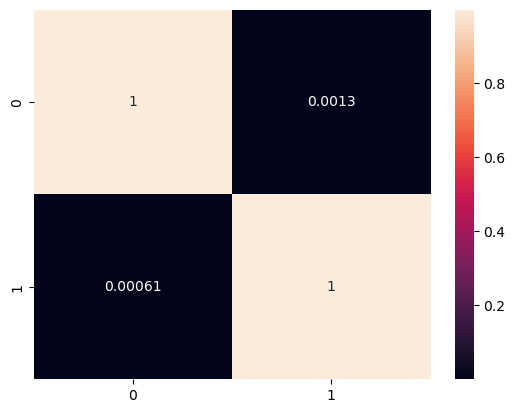

In [12]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True)
print(confusion_matrix(y_test, y_pred))

In [10]:
# On validation data
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix

y_predval = xgb_clf.predict(X_val)
print('Precision: ', precision_score(y_val, y_predval))
print('Recall: ', recall_score(y_val, y_predval))
print('F1: ', f1_score(y_val, y_predval))
print('ROC AUC: ', roc_auc_score(y_val, y_predval))

Precision:  0.9986884399284232
Recall:  0.9993705568720379
F1:  0.9990293819663499
ROC AUC:  0.9990271700748825


[[1264083    1666]
 [    799 1268577]]


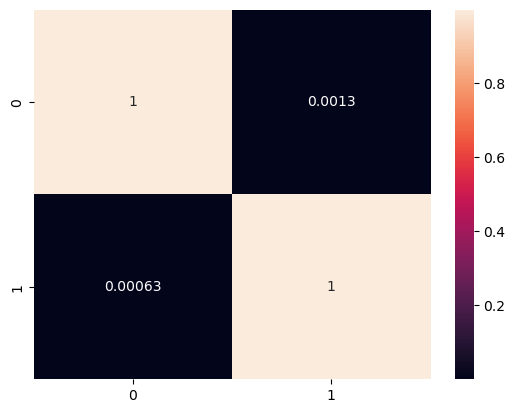

In [11]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_val, y_predval, normalize='true'), annot=True)
print(confusion_matrix(y_val, y_predval))

In [6]:
# let's try to improve the model by tuning the hyperparameters
# import optuna
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix

# define objective function with hyperparameters for XGBoost

def objective(trial):
    X = X_train
    y = y_train

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('subsample', 0.01, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'tree_method': 'gpu_hist',
    }

    XGB_clf = XGBClassifier(**params)
    XGB_clf.fit(X, y)
    y_prediction = XGB_clf.predict(X_val)
    score = f1_score(y_val, y_prediction)
    return score

In [7]:
study = optuna.create_study(direction='maximize')
#study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=50, show_progress_bar=True)
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2023-10-17 17:58:49,463] A new study created in memory with name: no-name-eaef1bca-8e57-4d5e-b75c-6b8dc94c8b13


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-17 17:58:50,774] Trial 0 finished with value: 0.9838167938931297 and parameters: {'n_estimators': 539, 'max_depth': 6, 'learning_rate': 0.058197518015835774, 'subsample': 0.5640873663475682, 'gamma': 2, 'min_child_weight': 7}. Best is trial 0 with value: 0.9838167938931297.
[I 2023-10-17 17:58:52,037] Trial 1 finished with value: 0.9653284671532847 and parameters: {'n_estimators': 966, 'max_depth': 5, 'learning_rate': 0.0946431828508867, 'subsample': 0.09728809951578957, 'gamma': 0, 'min_child_weight': 10}. Best is trial 0 with value: 0.9838167938931297.
[I 2023-10-17 17:58:53,143] Trial 2 finished with value: 0.9847188264058679 and parameters: {'n_estimators': 983, 'max_depth': 8, 'learning_rate': 0.05636328667971511, 'subsample': 0.9126740327386496, 'gamma': 2, 'min_child_weight': 9}. Best is trial 2 with value: 0.9847188264058679.
[I 2023-10-17 17:58:53,892] Trial 3 finished with value: 0.9521487351417252 and parameters: {'n_estimators': 820, 'max_depth': 6, 'learning_rat

In [18]:
optuna.visualization.plot_optimization_history(study)

In [19]:
optuna.visualization.plot_slice(study)

In [20]:
model_best_params = XGBClassifier(**study.best_params)
model_best_params.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04600547885721323,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=915, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
# save best model to json
model_best_params.save_model('./best_model.json')

In [8]:
study.best_params

{'n_estimators': 955, 'max_depth': 6, 'learning_rate': 0.025918490843308425, 'subsample': 0.9489427258507968, 'gamma': 0, 'min_child_weight': 2}


In [21]:
print('Results with best params on test data:')
y_pred2 = model_best_params.predict(X_test)
print('Precision: ', precision_score(y_test, y_pred2))
print('Recall: ', recall_score(y_test, y_pred2))
print('F1: ', f1_score(y_test, y_pred2))
print('ROC AUC: ', roc_auc_score(y_test, y_pred2))

Results with best params on test data:
Precision:  0.9994665101343403
Recall:  0.9999567015730713
F1:  0.9997115457644647
ROC AUC:  0.9997103392659933


[[1264193     678]
 [     55 1270199]]


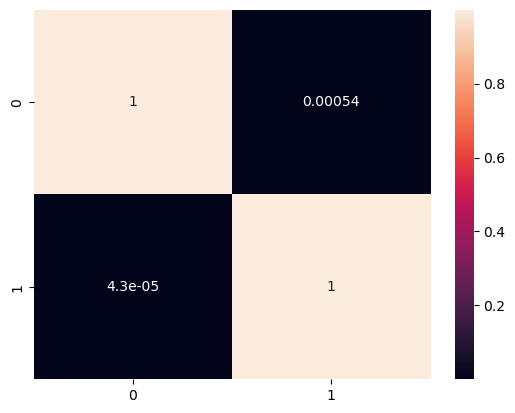

In [22]:
# Confusion Matrix on validation data
sns.heatmap(confusion_matrix(y_test, y_pred2, normalize='true'), annot=True)
print(confusion_matrix(y_test, y_pred2))

In [23]:
y_pred = model_best_params.predict(X_val)

In [24]:
print('Results with best params on validation data:')
print('Precision: ', precision_score(y_val, y_pred))
print('Recall: ', recall_score(y_val, y_pred))
print('F1: ', f1_score(y_val, y_pred))
print('ROC AUC: ', roc_auc_score(y_val, y_pred))

Results with best params on validation data:
Precision:  0.9994748014954378
Recall:  0.9999629739336493
F1:  0.9997188281197084
ROC AUC:  0.9997180066085546


[[1265082     667]
 [     47 1269329]]


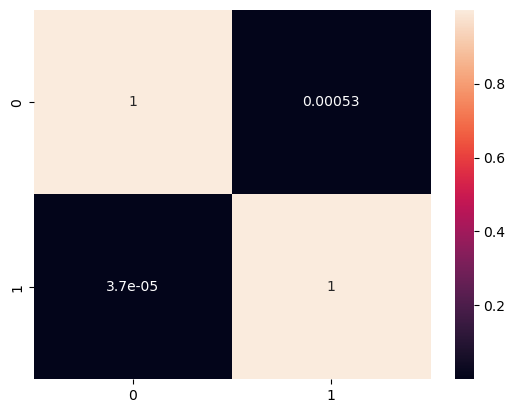

In [25]:
# Confusion Matrix on validation data
sns.heatmap(confusion_matrix(y_val, y_pred, normalize='true'), annot=True)
print(confusion_matrix(y_val, y_pred))

## not sure about this

In [26]:
# test predictions on full dataset

df_full = pd.read_csv('./data/PS_20174392719_1491204439457_log.csv')

#df_full = df_full.sample(n=100000)

# copy first letter of nameDest and to new column
df_full['nameOrig_first'] = df_full['nameOrig'].str[0]
df_full['nameDest_first'] = df_full['nameDest'].str[0]

# split data into train, test and validation sets
X_full = df_full.drop(['step','nameOrig','nameDest','isFraud', 'isFlaggedFraud'], axis=1)
y_full = df_full['isFraud']

# encode categorical data
le = LabelEncoder()
columns_to_encode = ['type', 'nameDest_first', 'nameOrig_first']
X_full[columns_to_encode] = X_full[columns_to_encode].apply(lambda col: le.fit_transform(col))

In [27]:
print('Results with best params on full data:')
y_pred_full = model_best_params.predict(X_full)
print('Precision: ', precision_score(y_full, y_pred_full))
print('Recall: ', recall_score(y_full, y_pred_full))
print('F1: ', f1_score(y_full, y_pred_full))
print('ROC AUC: ', roc_auc_score(y_full, y_pred_full))

Results with best params on full data:
Precision:  0.5379260524069088
Recall:  0.9973213198587605
F1:  0.6988907849829352
ROC AUC:  0.9981070284103415


[[6347371    7036]
 [     22    8191]]


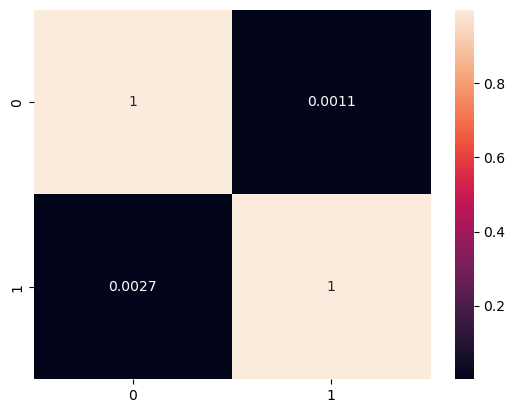

In [28]:
# Confusion Matrix on validation data
sns.heatmap(confusion_matrix(y_full, y_pred_full, normalize='true'), annot=True)
print(confusion_matrix(y_full, y_pred_full))

In [ ]:
"1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0"

In [38]:
# create fictional transaction to test the model: type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, nameOrig_first, nameDest_first
to_test = {
    'type': 5,
    'amount': 254,
    'oldbalanceOrg': 254,
    'newbalanceOrig': 0,
    'oldbalanceDest': 0,
    'newbalanceDest': 0,
    'nameOrig_first': 0,
    'nameDest_first': 0
}
to_test = pd.DataFrame([to_test])

skuska = model_best_params.predict(to_test)

# Interpret the prediction
if skuska[0] == 1:
    print("The model predicts that the transaction is fraudulent.")
else:
    print("The model predicts that the transaction is not fraudulent.")

The model predicts that the transaction is fraudulent.


In [ ]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time
 
# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 
 
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]
 
# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)
 
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)
/databricks/python/lib/python3.10/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)